# Predicting Stock Movements by Analyzing News Data

## Importing Packages

In [28]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

# options

pd.set_option('display.max_columns', None)

## Preparing the News Data

### Importing Data

In [2]:
# import news data

df_news = pd.read_csv('data/news_data.csv')
df_news.info()

C:\Users\nicol\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823480 entries, 0 to 823479
Data columns (total 48 columns):
TIMESTAMP_UTC           823480 non-null object
RPNA_DATE_UTC           823480 non-null object
RPNA_TIME_UTC           823480 non-null object
RP_ENTITY_ID            823480 non-null object
ENTITY_TYPE             823480 non-null object
ENTITY_NAME             823480 non-null object
POSITION_NAME           5568 non-null object
RP_POSITION_ID          5568 non-null object
COUNTRY_CODE            823480 non-null object
RELEVANCE               823480 non-null int64
TOPIC                   45300 non-null object
GROUP                   45300 non-null object
TYPE                    45300 non-null object
SUB_TYPE                21440 non-null object
PROPERTY                14679 non-null object
EVALUATION_METHOD       0 non-null float64
MATURITY                0 non-null float64
CATEGORY                45300 non-null object
ESS                     45300 non-null float64
AES            

### Calculating Next Market Date

In [3]:
# change formats

df_news['TICKER'] = df_news['COMPANY'].str[3:]
df_news['TIMESTAMP_UTC'] = pd.to_datetime(df_news['TIMESTAMP_UTC'], utc = True)
df_news['RPNA_DATE_UTC'] = df_news['TIMESTAMP_UTC'].dt.date
df_news['RPNA_TIME_UTC'] = df_news['TIMESTAMP_UTC'].dt.time

In [4]:
# convert UTC to Eastern Standard Time

df_news['TIMESTAMP_EST'] = df_news['TIMESTAMP_UTC'].dt.tz_convert('America/New_York')
df_news['RPNA_DATE_EST'] = df_news['TIMESTAMP_EST'].dt.date
df_news['RPNA_TIME_EST'] = df_news['TIMESTAMP_EST'].dt.time

# get next market day for every observation (news) according to the US trading calendar

from pandas.tseries.offsets import CustomBusinessDay

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, \
    USMartinLutherKingJr, USPresidentsDay, GoodFriday, USMemorialDay, \
    USLaborDay, USThanksgivingDay

class USTradingCalendar(AbstractHolidayCalendar):
    rules = [Holiday('NewYearsDay', month = 1, day = 1, observance = nearest_workday),
             USMartinLutherKingJr,
             USPresidentsDay,
             GoodFriday,
             USMemorialDay,
             Holiday('USIndependenceDay', month = 7, day = 4, observance = nearest_workday),
             USLaborDay,
             USThanksgivingDay,
             Holiday('Christmas', month = 12, day = 25, observance = nearest_workday)]

bday_us = CustomBusinessDay(calendar = USTradingCalendar())
nasdaq_close = '16:00:00'

df_news['NEXT_MARKET_DATE'] = pd.to_datetime(np.where(df_news['RPNA_TIME_EST'] > pd.to_datetime(nasdaq_close).time(),
                                                      df_news['RPNA_DATE_EST'] + bday_us,
                                                      df_news['RPNA_DATE_EST'] + 0 * bday_us))
df_news['NEXT_MARKET_CLOSE'] = (df_news['NEXT_MARKET_DATE'] + pd.Timedelta(nasdaq_close)).dt.tz_localize('America/New_York')
df_news['TIME_TO_CLOSE'] = df_news['NEXT_MARKET_CLOSE'] - df_news['TIMESTAMP_EST']

'''
the algortihm is working as intended: the stock market was closed from 1st to 3rd January 
-> next market day on 4th January
'''

df_news[['TIMESTAMP_EST', 'NEXT_MARKET_DATE', 'NEXT_MARKET_CLOSE', 'TIME_TO_CLOSE']].head(5)


,TIMESTAMP_EST,NEXT_MARKET_DATE,NEXT_MARKET_CLOSE,TIME_TO_CLOSE
0,2016-01-01 05:30:01.663000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,3 days 10:29:58.337000
1,2016-01-01 05:44:40.104000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,3 days 10:15:19.896000
2,2016-01-03 18:35:51.992000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,0 days 21:24:08.008000
3,2016-01-04 00:08:02.003000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,0 days 15:51:57.997000
4,2016-01-04 02:05:01.705000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,0 days 13:54:58.295000


## Preparing the Market Data

### Importing Data

In [5]:
# import market data

df_market = pd.read_csv('data/djia.csv')
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28248 entries, 0 to 28247
Data columns (total 12 columns):
gvkey       28248 non-null int64
iid         28248 non-null int64
datadate    28248 non-null object
tic         28248 non-null object
conm        28248 non-null object
cshtrd      28221 non-null float64
prccd       28221 non-null float64
prchd       28221 non-null float64
prcld       28221 non-null float64
prcod       27876 non-null float64
trfd        28222 non-null float64
exchg       28248 non-null int64
dtypes: float64(6), int64(3), object(3)
memory usage: 2.6+ MB


In [6]:
# change formats

df_market['datadate'] = pd.to_datetime(df_market['datadate'],
                                       dayfirst = True)

### Calculating Abnormal Return

In [7]:
# compute stock return and volatility

df_market['dreturn'] = np.log(df_market.prccd / df_market.prcod)
df_market['dvar'] = ((np.log(df_market.prchd) - np.log(df_market.prcld))**2) / 4 * np.log(2) #Applying the Parkinson (1980) H-L measure
df_market['dvol'] = np.sqrt(df_market.dvar)
df_market['dreturn_flag'] = np.where(df_market['dreturn'] >= 0, 1, -1)

In [8]:
market_return=pd.read_csv('data/gspc.csv')
market_return['mkt_return'] = np.log(market_return.Close / market_return.Open)
market_return=market_return[['Date','mkt_return']]
market_return.columns=['datadate','mkt_return']
market_return['datadate'] = pd.to_datetime(market_return['datadate'])
market_return.head(1)

,datadate,mkt_return
0,2015-12-31,-0.008113


In [9]:
df_market=pd.merge(df_market, market_return,how='left',on='datadate')
df_market.head(1)

,gvkey,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,trfd,exchg,dreturn,dvar,dvol,dreturn_flag,mkt_return
0,1447,1,2016-01-04,AXP,AMERICAN EXPRESS CO,9228601.0,67.59,68.18,66.77,68.09,2.417612,11,-0.00737,0.000076,0.008699,-1,-0.01261


In [10]:
#remove row if closing price or market return is missing
df_market = df_market[np.isfinite(df_market['prcod'])]
df_market = df_market[np.isfinite(df_market['mkt_return'])]

In [11]:
#get covariance
grouped = df_market.groupby('conm')
group_cov=grouped.apply(lambda x: x['dreturn'].cov(x['mkt_return']))
group_cov=pd.DataFrame(data=group_cov)
group_cov.columns = ['cov']
group_cov.reset_index(inplace=True)

#get market variance
market_var=(df_market.groupby('conm')['mkt_return'].var())
market_var=pd.DataFrame(data=market_var)
market_var.columns = ['var']
market_var.reset_index(inplace=True)

merged_df=pd.merge(group_cov, market_var,how='left',on='conm')
#merged_df

merged_df['beta']=merged_df['cov']/merged_df['var']
merged_df

,conm,cov,var,beta
0,3M CO,0.000033,0.000041,0.794666
1,AMERICAN EXPRESS CO,0.000034,0.000041,0.833967
2,APPLE INC,0.000038,0.000041,0.927551
3,BOEING CO,0.000044,0.000041,1.067496
4,CATERPILLAR INC,0.000048,0.000041,1.172869
5,CHEVRON CORP,0.000032,0.000041,0.784118
6,CISCO SYSTEMS INC,0.000042,0.000041,1.014859
7,COCA-COLA CO,0.000019,0.000041,0.450555
8,DISNEY (WALT) CO,0.000027,0.000041,0.647995
9,EXXON MOBIL CORP,0.000024,0.000041,0.575956


In [12]:
df_market=pd.merge(df_market, merged_df,how='left',on='conm')

In [13]:
#average market return over 2016-2018 period
averagereturn=market_return["mkt_return"].mean()

In [14]:
#compute abnormal return
df_market['exp_return']=df_market['beta']*df_market['mkt_return']
df_market['abnormal_return']=df_market['dreturn']-df_market['exp_return']
df_market['abnormal_return_flag'] = np.where(df_market['abnormal_return'] >= 0, 1, -1)
df_market.head(1)

,gvkey,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,trfd,exchg,dreturn,dvar,dvol,dreturn_flag,mkt_return,cov,var,beta,exp_return,abnormal_return,abnormal_return_flag
0,1447,1,2016-01-04,AXP,AMERICAN EXPRESS CO,9228601.0,67.59,68.18,66.77,68.09,2.417612,11,-0.00737,0.000076,0.008699,-1,-0.01261,0.000034,0.000041,0.833967,-0.010516,0.003146,1


## Joining News and Market Data

In [15]:
# join news data and market data on market date and company

df = pd.merge(df_news, df_market, how = 'inner',
              left_on = ['NEXT_MARKET_DATE', 'TICKER'],
              right_on = ['datadate', 'tic'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785719 entries, 0 to 785718
Data columns (total 78 columns):
TIMESTAMP_UTC           785719 non-null datetime64[ns, UTC]
RPNA_DATE_UTC           785719 non-null object
RPNA_TIME_UTC           785719 non-null object
RP_ENTITY_ID            785719 non-null object
ENTITY_TYPE             785719 non-null object
ENTITY_NAME             785719 non-null object
POSITION_NAME           5150 non-null object
RP_POSITION_ID          5150 non-null object
COUNTRY_CODE            785719 non-null object
RELEVANCE               785719 non-null int64
TOPIC                   42546 non-null object
GROUP                   42546 non-null object
TYPE                    42546 non-null object
SUB_TYPE                20285 non-null object
PROPERTY                13939 non-null object
EVALUATION_METHOD       0 non-null float64
MATURITY                0 non-null float64
CATEGORY                42546 non-null object
ESS                     42546 non-null float64
AE

In [16]:
# drop columns with no explanatory worth

drop = ['ENTITY_TYPE', 'RP_POSITION_ID', 'COUNTRY_CODE','TIMESTAMP_EST','RPNA_DATE_EST','RPNA_TIME_EST',
        'TIME_TO_CLOSE','RPNA_DATE_UTC','RPNA_TIME_UTC','ENTITY_NAME', 'EVALUATION_METHOD', 'ENS_KEY',
        'G_ENS_KEY', 'EVENT_SIMILARITY_KEY', 'RP_STORY_ID', 'PRODUCT_KEY', 'COMPANY', 'ISIN', 'BER', 'ANL_CHG',
        'TICKER', 'NEXT_MARKET_DATE', 'NEXT_MARKET_CLOSE', 'gvkey', 'iid', 'datadate', 'tic', 'conm', 'cshtrd',
        'prccd', 'prchd', 'prcld', 'prcod', 'trfd', 'exchg', 'RP_ENTITY_ID','cov','var','beta','exp_return']
df = df.drop(drop, axis = 1)

## Data Cleaning

In [17]:
# show missing data in rows

missing = (df.isnull().sum(axis = 1) / df.isnull().count(axis = 1)).sort_values(ascending = False)
missing_rows = pd.concat([missing], axis = 1, keys = ['Missing'])
drop_rows = missing_rows[missing_rows['Missing'] > 0.25]
drop_rows.count()

Missing    743173
dtype: int64

In [18]:
# drop observations where most features are missing

df = df.drop(drop_rows.index, axis = 0)

In [19]:
# show missing data in columns

total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = False)
missing_clmns = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_clmns.head(5)

,Total,Percent
MATURITY,42546,1.000000
POSITION_NAME,37396,0.878955
PROPERTY,28607,0.672378
SUB_TYPE,22261,0.523222
ESS,0,0.000000


In [20]:
# drop features where most observations are missing

df = df.drop((missing_clmns[missing_clmns['Percent'] > 0.25]).index, axis = 1)

In [21]:
# check if missing values remain

df.isnull().sum().max()

0

## Data Exploration

C:\Users\nicol\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


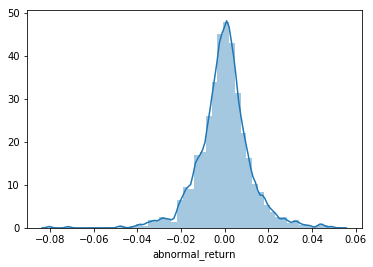

In [29]:
# check distribution of return

sns.distplot(df['abnormal_return']);

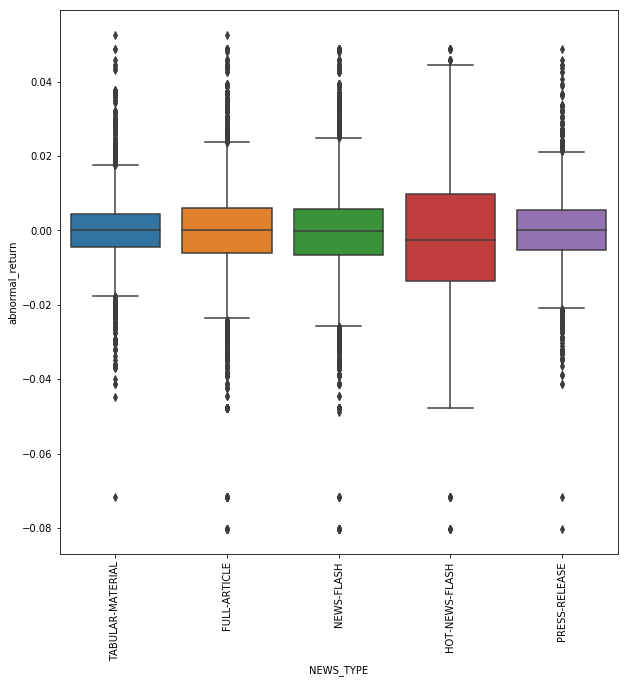

In [42]:
var_x = 'NEWS_TYPE'
var_y = 'abnormal_return'
data = pd.concat([df[var_x], df[var_y]], axis = 1)
plt.subplots(figsize = (10, 10))
fig = sns.boxplot(x = var_x, y = var_y, data = data)
plt.xticks(rotation = 90);

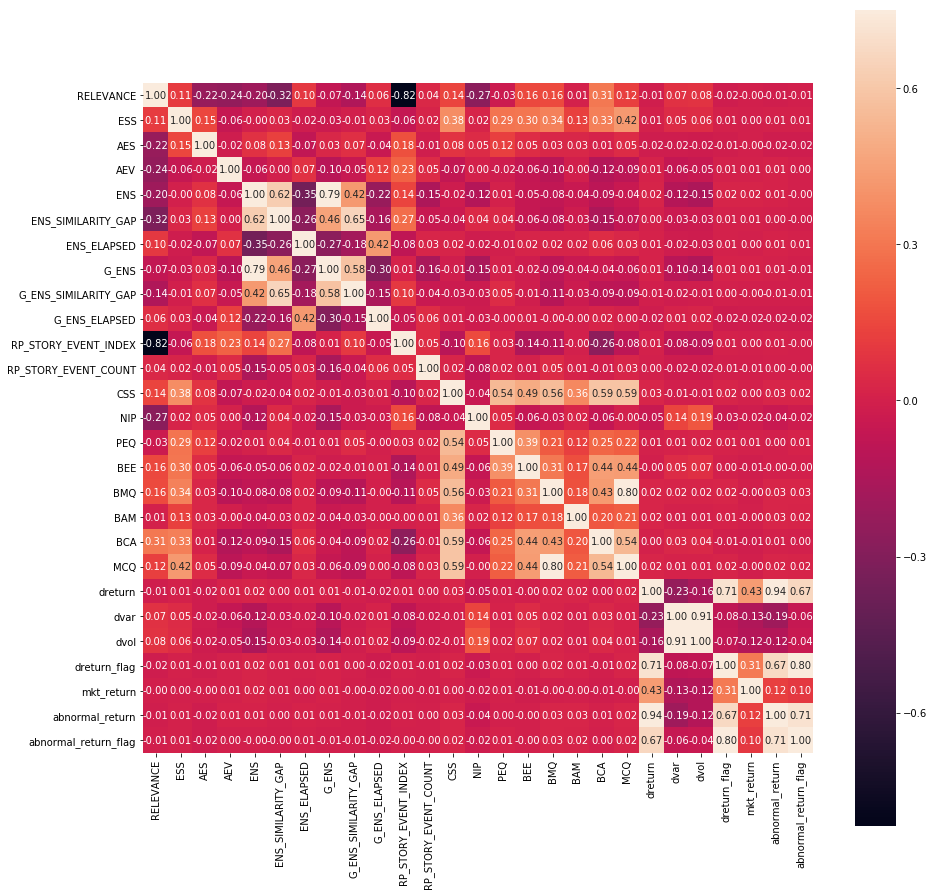

In [24]:
# check correlation of all variables
corrmat = df.corr()
plt.subplots(figsize = (15, 15))
sns.heatmap(corrmat, vmax = 0.75, square = True, annot = True, fmt='.2f');

# visualize relationship between the most correlated variables

#cols = corrmat.nlargest(5, 'dvol')['dvol'].index
#sns.pairplot(df[cols])
#plt.show()

## Preparing Data for Classification

In [36]:
# assigning feature matrix and output variable

X = df[['RELEVANCE','GROUP','ESS','AES','AEV','ENS','ENS_SIMILARITY_GAP', 'ENS_ELAPSED','G_ENS',
        'G_ENS_SIMILARITY_GAP','G_ENS_ELAPSED','NEWS_TYPE','RP_STORY_EVENT_INDEX', 'RP_STORY_EVENT_COUNT',
        'CSS','NIP','PEQ','BEE','BMQ','BAM','BCA','MCQ']]
y = df['abnormal_return_flag']

In [37]:
# transform nominal features to dummy features
X = pd.get_dummies(X)

In [38]:
# create interaction terms

from sklearn.preprocessing import PolynomialFeatures
X = PolynomialFeatures(interaction_only=True, include_bias=False).fit_transform(X)

## Model Selection

### Assessing feature importance with Random Forests

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     random_state=0, 
                     stratify=y)
X_train.shape, X_test.shape

feat_labels = X.columns[0:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]


from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of samples that meet this criterion:', 
      X_selected.shape[0])

for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

Number of samples that meet this criterion: 31909
 1) AEV                            0.173466
 2) AES                            0.137476
 3) G_ENS_SIMILARITY_GAP           0.102532


### PCA Decomposition

In [38]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(0, 58), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(0, 58), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_02.png', dpi=300)
plt.show()

NameError: name 'X_train_std' is not defined

### Comparison of Classifiers

In [40]:
# compare different classifiers

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

classifiers = [
    LogisticRegression(),
    RandomForestClassifier(),
    #SVC(),
    #GaussianNB(),
    #KNeighborsClassifier()
    ]

clf_columns = [['Name', 'Accuracy', 'Accuracy', 'Precision', 'Precision', 'Recall', 'Recall'],
               ['', 'Train', 'Test', 'Train', 'Test', 'Train', 'Test']]


clf_table = pd.DataFrame(columns = clf_columns)

for i, clf in enumerate(classifiers):
    
    print(i)
    clf_name = clf.__class__.__name__
    clf_table.loc[i, 'Name'] = clf_name
    
    pipe = make_pipeline(StandardScaler(), clf)
    
    cv = cross_validate(clf, X, y, scoring = ['accuracy', 'precision', 'recall'],
                        return_train_score = True, cv = 5)
    
    clf_table.loc[i, ('Accuracy', 'Train')] = cv['train_accuracy'].mean()
    clf_table.loc[i, ('Accuracy', 'Test')] = cv['test_accuracy'].mean()
    clf_table.loc[i, ('Precision', 'Train')] = cv['train_precision'].mean()
    clf_table.loc[i, ('Precision', 'Test')] = cv['test_precision'].mean()
    clf_table.loc[i, ('Recall', 'Train')] = cv['train_recall'].mean()
    clf_table.loc[i, ('Recall', 'Test')] = cv['test_recall'].mean()

clf_table.sort_values(by = [('Accuracy', 'Train')], ascending = False, inplace = False)
clf_table

0
1


Name  Accuracy           Precision              Recall  \
                              Train      Test     Train      Test     Train   
0      LogisticRegression  0.504707  0.488765  0.506372  0.484372  0.511467   
1  RandomForestClassifier   0.98625  0.493866  0.993885  0.493323  0.978554   

             
       Test  
0  0.471733  
1  0.387734